# Training machine learning models on credit card transactions labeled as fraudulent or genuine

### The dataset contains transactions made by group credit card holders in September 2013 over a span of two days. There are 284,807 transactions with only 492 frauds, meaning the dataset is highly unbalanced. The positive class (frauds) account for 0.172% of all transactions.

### The dataset contains numerical input variables that are the result of a PCA transformation. Due to confidentiality issues, the original features and more background information about the data are not shown. There are 28 features, namely V1, V2, ...V27, which are principal components obtained using PCA, except for the Time and Amount features. The Class feature is the response variable and it takes the value 1 in a case of fraud and 0 otherwise.

### There are two additional features, Time and Amount. The Time column signifies the time in seconds between each transaction and the first transaction, whereas the Amount column signifies how much money was transferred in this transaction. 

### Source: https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

<h7> Shahab Athari, leading Advisor for Control and Economic Analysis in Equinor.com located in Houston, Texas.</h7> 

In [174]:
#Import Python libraries that will be used in this model
%matplotlib inline
from scipy.stats import randint as sp_randint
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing, decomposition
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA as sklearn_pca
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import seaborn as sns 
import sklearn
import sklearn.cross_validation 
import sklearn.tree
import time
import timeit
import warnings 
warnings.simplefilter('ignore')

In [175]:
path1 = ("C:/Users/aath/Dropbox/MAEN/DS/data/Kaggle/cc/creditcard.csv")
n = sum(1 for line in open(path1)) - 1 #number of records in file (excludes header)
s = 284807 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(path1, skiprows=skip)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [176]:
# Check the timespan of the data 
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))

Total time spanning: 2.0 days


In [177]:
# Check the percentage fraud cases
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

0.173 % of all transactions are fraud. 


We can see that the feature space is very imbalance and fraud cases are very rare. Becasue of this we should be very careful about our learner selection as the risk of overfitting is very high.

(0, 50000)

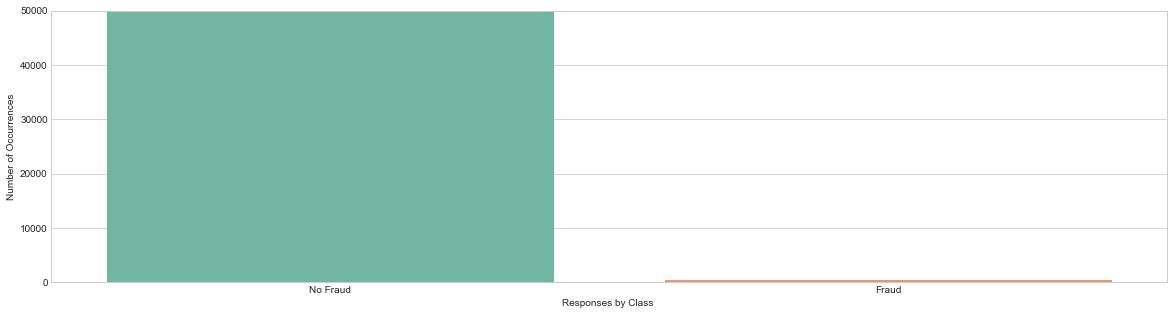

In [178]:
# To show the imbalance in first 50,000 data
plt.figure(figsize=(20, 5))
sns.set_style("whitegrid")
plt.subplot(1, 1, 1)
ax = sns.countplot(x="Class", data=df, palette="Set2")
ax.set_xlabel('Responses by Class ')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['No Fraud','Fraud'], fontsize=10)
plt.ylim(0, 50000)

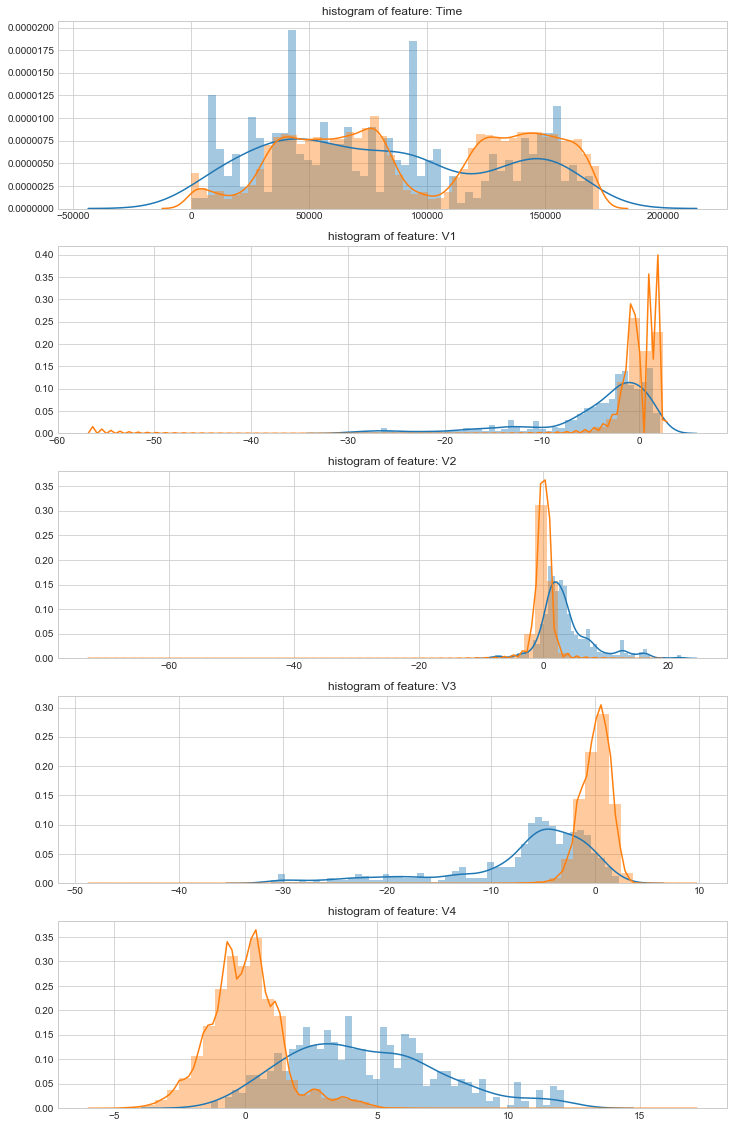

In [179]:
# let's draw the histogram for first five features:

import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

# Above code will raise a warning related to deprecated function. And to avoid seeing this warning
# we suppress it using: 
warnings.simplefilter('ignore')

Histograms of 5 features are highly skewed. In addition, the dataset does not have many features, so trimming the tails would lose important information. 

## Dealing with class imbalance

Class imbalance can negatively influence both the evaluatiuon of learning algorithms and also the learning process during the fitting stage. For machine learning algorithms we typically optimize a reward or cost function that is computed as a sum over the training examples that it sees during fitting. Becasue of this the decision rule is likely going to be biased towards the majority class. 

One way to address this is to assign a larger penalty to wrong predictions on the minority class. Alternatively, we can include upsampling the minority class, downsampling the majority class or generate synthetic training samples. Unfortunately, there's no universally best solution, no technique that works best across different problem domains. In this case we will use the upsampling of the Fraud case.

In [180]:
# Create a separate table for each class
df_minority = df[df.Class == 1]
df_majority = df[df.Class == 0]

# Determine the  size of minority class
minority_size = len(df[df['Class'] == 1])
majority_size = len(df[df['Class'] == 0])

# Upsample the minority case
minority_upsampled = resample(df_minority, replace=True, n_samples=majority_size, random_state=140)

# Combine in a new dataframe 'data' the majority class with the upsampled minority class
balanced_df = pd.concat([df_majority,minority_upsampled])
 
# Display new class counts
balanced_df.Class.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [181]:
# Becasue of high computational cost we will use only a random sample 
# from previous balanced dataset for futher analysis
small_sample_size = 50000
small_balanced_df=balanced_df.sample(small_sample_size, random_state=2)

In [182]:
# Setup a new dataframe that contains the features per Class, dropping the time
features_only = small_balanced_df.drop(['Time'],axis = 1)

In [183]:
#Describe the data using statistics
features_only.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,-2.366613,1.807080,-3.501406,2.264490,-1.554166,-0.695873,-2.785006,0.276881,-1.286858,-2.827627,...,0.360162,0.010912,-0.015906,-0.054811,0.020844,0.024895,0.083934,0.038658,101.901876,0.499920
std,5.511105,3.710981,6.184603,3.206984,4.205747,1.758031,5.840225,4.885729,2.324148,4.525958,...,2.820352,1.176923,1.202467,0.565677,0.671749,0.474596,1.012620,0.452836,237.996206,0.500005
min,-40.042537,-38.430842,-31.103685,-5.416315,-22.105532,-23.496714,-43.557242,-41.044261,-13.434066,-24.588262,...,-22.797604,-8.887017,-36.666000,-2.766638,-6.712624,-1.544086,-9.895244,-8.187460,0.000000,0.000000
25%,-2.869795,-0.143147,-5.126307,-0.121588,-1.774329,-1.574565,-3.103570,-0.203205,-2.309829,-4.565260,...,-0.167384,-0.532228,-0.239303,-0.403114,-0.315773,-0.285325,-0.063019,-0.058658,1.460000,0.000000
50%,-0.769172,0.962831,-1.377266,1.314446,-0.432996,-0.654659,-0.659424,0.152908,-0.717418,-0.870997,...,0.150303,0.033958,-0.033496,0.004250,0.049970,-0.015477,0.048731,0.034808,18.400000,0.000000
75%,1.063102,2.809257,0.337000,4.243069,0.478883,0.074805,0.261768,0.866964,0.174216,0.021653,...,0.650988,0.591928,0.192517,0.370793,0.394050,0.323885,0.453867,0.218690,99.990000,1.000000
max,2.418802,22.057729,4.069865,12.114672,34.099309,13.055580,25.971058,20.007208,9.125535,13.164571,...,27.202839,8.361985,18.946734,3.998294,5.521140,3.122747,8.708972,15.870474,6982.670000,1.000000


Above table reconfirmed that the distributions for each feature is highly skewed.
We also can see that scale of each feature differs and this can cause suboptimal learning especially when using classification method. Therefore, to improve the predictive accuracy, we will scale the data using a Standard Normal Distribution N(0,1):

In [184]:
names = features_only.columns # Create the headings only of the dataframe
names = names[:-1] # drop last column of the table

In [185]:
# Standardize the feature set
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_only[names] = scaler.fit_transform(features_only[names])
scaled_features_only = features_only # Scaled features

Do we have any similarities between the features? And one way to check that is visually inspection the correlation matrix between the features

In [186]:
features_only_scaled = features_only # Create a copy of features

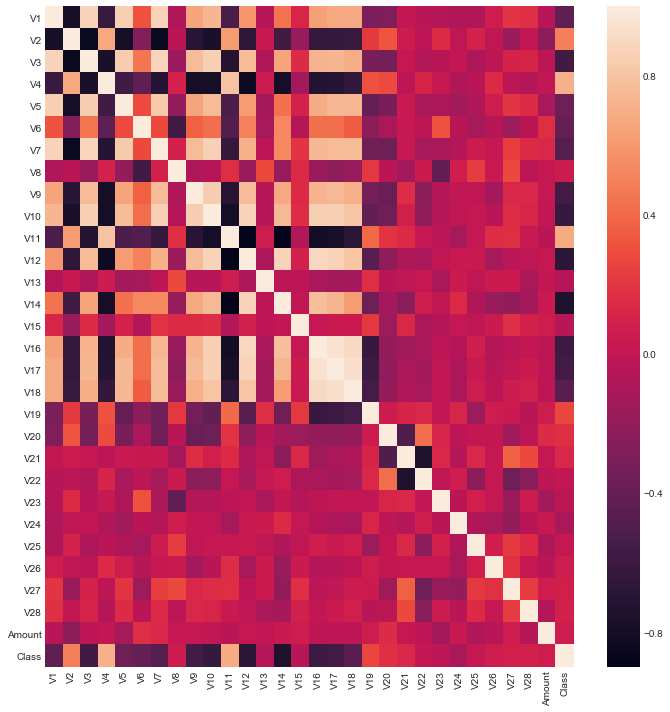

In [187]:
correlation_mat = scaled_features_only.corr()

#Plot heatmap
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_mat)  # use this if want text added to each box annot=True
plt.tight_layout()
plt.show()

Almost all of the features are not similar to one another, meaning our dataset is fairly diverse. This is yet another confirmation that we should keep all our feature space.

### Training, validation, and testing set preparation
Priot to model selection we need to split the data into training, development (i.e. validation), and test set. We are using first 80% of the data as the training and validation set. The remaining 20% will be used as the testing set:

In [188]:
TEST_RATIO = 0.20
#scaled_features_only.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * scaled_features_only.shape[0])
train_x = scaled_features_only.iloc[:TRA_INDEX, 1:-2].values
train_y = scaled_features_only.iloc[:TRA_INDEX, -1].values
test_x = scaled_features_only.iloc[TRA_INDEX:, 1:-2].values
test_y = scaled_features_only.iloc[TRA_INDEX:, -1].values

# Number of cross validation used for all models
CF_no = 5

## Logistic regression model

In [189]:
#Start the timer as a measure of the computing effort
start_time = time.time()

# Check any overfitting problem using Cross Fold validation
log_reg = sklearn.linear_model.LogisticRegression()
score = sklearn.cross_validation.cross_val_score(log_reg, train_x, train_y, cv=CF_no)
print(score)

[0.94 0.94 0.94 0.94 0.94]


In [190]:
#Tune parameters
# C parameter
c_param = [0.1,0.5,1, 2, 5, 10]

#Tune the type of penalty used between l1 and l2
penalty_type = ['l1','l2']
parameters = {'C': c_param, 'penalty': penalty_type}

#Fit parameters
%timeit  
log_reg_tuned = GridSearchCV(log_reg, param_grid=parameters, cv=CF_no)

#Fit the tunned classifier in the traiing space
log_reg_tuned.fit(train_x, train_y)

#Print the best parameters
print(log_reg_tuned.best_params_)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

{'C': 10, 'penalty': 'l1'}
--- 3002 seconds ---


In [191]:
# Check the prediction power of the model
pred_y = np.array(log_reg_tuned.predict(test_x))
true_y = np.array(test_y)

### Evaluating the model
Below we will use the confusion matrix which is a way of tabulating the number of misclassifications. Also, we can see the number of predicted classes which were categorized wrongly as true. But before that we need to set up a function that also plots the outcome of this matrix.

In [192]:
# A function to create confusion matrix. Part 1 of 2
# This is part 1 that can be used for all models. Part 2 depends on model specific data

import itertools  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4914  123]
 [ 406 4557]]


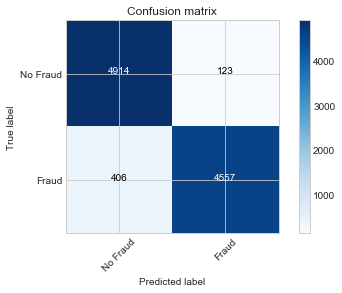

In [193]:
# A function to create confusion matrix. Part 2 of 2
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)

In [194]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.92      0.98      0.95      5037
    class 1       0.97      0.92      0.95      4963

avg / total       0.95      0.95      0.95     10000



In [195]:
# Metrics computed from a confusion matrix

#cnf_matrix_metrics = metrics.confusion_matrix(test_y, pred_y)
#[row, column]
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

# Classification Accuracy: Overall, how often is the classifier correct?
print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 4557. 
True Negatives (TN): we correctly predicted that no fraud: 4914. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 123. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 406. 
Overall, how often is the classifier correct (accuracy)? 0.9471. 
Overall, how often is the classifier incorrect? 0.0529. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 0.918194640338505.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9755807027992853.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.024419297200714712.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9737179487179487.


In [196]:
# Which metrics should you focus on?
# This is the case of fraud detection therefore we should optimize for sensitivity or recall:
# FN is in this case more important as false positives (normal transactions that are marked as possible fraud
# are more acceptable than false negatives where actual fraud has happened and we fail to detect

Next, we will try a different model to see if we can reduce this error.

## Decision Tree

In [197]:
#Start the timer as a measure of the computing effort
start_time = time.time()

D_tree = DecisionTreeClassifier(random_state=37)
score = sklearn.cross_validation.cross_val_score(D_tree, train_x, train_y, cv=CF_no)
print(score)

[1. 1. 1. 1. 1.]


In [198]:
D_tree = DecisionTreeClassifier(random_state=37)
params = {"max_depth": [2, 5, 10, 15], "min_samples_leaf": sp_randint(1, 5), 
          "criterion": ["gini", "entropy"]}

D_tree_tuned = RandomizedSearchCV(D_tree, params)
D_tree_tuned.fit(train_x,train_y)

#Print the best parameters
print(D_tree_tuned.best_params_)  

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3}
--- 16 seconds ---


In [199]:
# Check the prediction power of the model
pred_y = np.array(D_tree_tuned.predict(test_x))
true_y = np.array(test_y)

Confusion matrix, without normalization
[[5011   26]
 [   0 4963]]


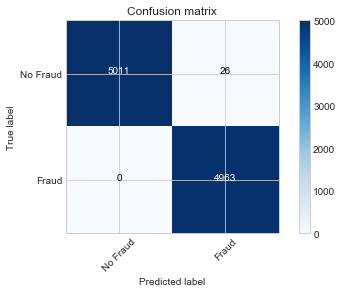

In [200]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [201]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(true_y, pred_y, target_names=target_names))

             precision    recall  f1-score   support

    class 0       1.00      0.99      1.00      5037
    class 1       0.99      1.00      1.00      4963

avg / total       1.00      1.00      1.00     10000



In [202]:
# Metrics computed from a confusion matrix

#cnf_matrix_metrics = metrics.confusion_matrix(test_y, pred_y)
#[row, column]
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

# Classification Accuracy: Overall, how often is the classifier correct?
print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 4963. 
True Negatives (TN): we correctly predicted that no fraud: 5011. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 26. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 0. 
Overall, how often is the classifier correct (accuracy)? 0.9974. 
Overall, how often is the classifier incorrect? 0.0026. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 1.0.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9948381973396864.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.005161802660313679.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9947885347765083.


## Random Forest

In [203]:
#Start the timer as a measure of the computing effort
start_time = time.time()

Random_f = ensemble.RandomForestClassifier()

# Fold Cross validation
score = sklearn.cross_validation.cross_val_score(Random_f, train_x, train_y, cv=CF_no)

# Fold Cross validation
print("Scores of cross fold validation: {}".format(score), " by {} number of foldings ".format(CF_no))

Scores of cross fold validation: [1. 1. 1. 1. 1.]  by 5 number of foldings 


In [204]:
Random_f.fit(train_x, train_y)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
print(Random_f.feature_importances_)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

[0.06 0.02 0.09 0.01 0.01 0.15 0.01 0.04 0.03 0.14 0.06 0.01 0.09 0.01
 0.01 0.14 0.01 0.02 0.01 0.04 0.01 0.   0.01 0.01 0.01 0.01 0.01]
--- 6 seconds ---


In [205]:
# Check the prediction power of the model
pred_y = np.array(Random_f.predict(test_x))
true_y = np.array(test_y)

Confusion matrix, without normalization
[[5034    3]
 [   0 4963]]


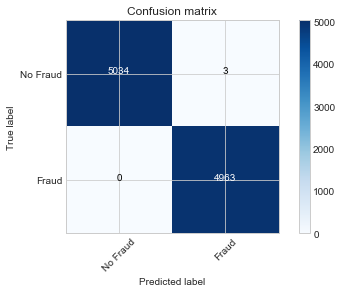

In [206]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [207]:
# Metrics computed from a confusion matrix

#cnf_matrix_metrics = metrics.confusion_matrix(test_y, pred_y)
#[row, column]
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

# Classification Accuracy: Overall, how often is the classifier correct?
print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 4963. 
True Negatives (TN): we correctly predicted that no fraud: 5034. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 3. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 0. 
Overall, how often is the classifier correct (accuracy)? 0.9997. 
Overall, how often is the classifier incorrect? 0.0003. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 1.0.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9994044073853484.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.0005955926146515784.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9993958920660492.


In [208]:
# Which metrics should you focus on?
# This is the case of fraud detection therefore we should optimize for sensitivity or recall:
# FN is in this case more important as false positives (normal transactions that are marked as possible fraud
# are more acceptable than false negatives where actual fraud has happened and we fail to detect

We try another model.

## Naive Bayes

In [209]:
# Prepare dataframe tables
X = scaled_features_only.iloc[:, 1:-2].values
y = scaled_features_only.iloc[:, -1].values

In [211]:
X_train = scaled_features_only.iloc[:TRA_INDEX, 1:-2].values
y_train = scaled_features_only.iloc[:TRA_INDEX, -1].values
X_test = scaled_features_only.iloc[TRA_INDEX:, 1:-2].values
y_test = scaled_features_only.iloc[TRA_INDEX:, -1].values

In this classification exercise we are also interested in the associated probabilities. These probabilities give us a some kind of confidence on the prediction. However, not all classifiers provide well-calibrated probabilities, some being over-confident while others being under-confident. Thus, a separate calibration of predicted probabilities is often desirable as a postprocessing. Below we use different calibration methods to evaluate the quality of the returned probabilities using Brier’s score.

In [212]:
# Use the Brier score which measures the accuracy of probabilistic predictions. 
# It is applicable to tasks in which predictions must assign probabilities to a set of mutually 
# exclusive discrete outcomes.”
# This function returns a score of the mean square difference between 
# the actual outcome and the predicted probability of the possible outcome. 
# The actual outcome has to be 1 or 0 (true or false), while the predicted probability of the actual 
# outcome can be a value between 0 and 1.

# The brier score loss is also between 0 to 1 and the lower the score (the mean square difference is smaller), 
# the more accurate the prediction is. 
# It can be thought of as a measure of the “calibration” of a set of probabilistic predictions.

#Start the timer as a measure of the computing effort
start_time = time.time()

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=CF_no, method='isotonic')
clf_isotonic.fit(X_train, y_train) #, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=CF_no, method='sigmoid')
clf_sigmoid.fit(X_train, y_train) #, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf) # , sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic) # , sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid) # , sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)


#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

Brier scores: (the smaller the better)
No calibration: 0.078
With isotonic calibration: 0.076
With sigmoid calibration: 0.070
--- 1 seconds ---


Based on Brier scores isotoic calibration is working best. 

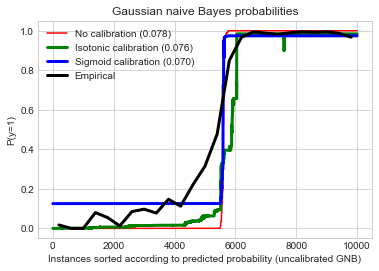

In [213]:
# Plot the predicted probabilities
plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)

plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)

plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)

plt.plot(np.linspace(0, y_test.size, 51)[1::2], y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')

plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

Below we continue using Naive Bayes caliberated with isotonic method. 

In [214]:
# We see isotonic calibration is performing best and below we run model evaluation on this version of Naive Bayes

y_pred_test = clf_sigmoid.predict(X_test)

#Print the time required to fit and evaluate the model
start_time = time.time()
print("Computational efforts: %s seconds ---" % (time.time() - start_time))

clf_isotonic_accuracy = accuracy_score(y_pred=y_pred_test, y_true=y_test)
clf_isotonic_precision = precision_score(y_pred=y_pred_test, y_true=y_test)
clf_isotonic_recall = recall_score(y_pred=y_pred_test, y_true=y_test)

print("Accuracy: {}. ".format(clf_isotonic_accuracy))
print("Precision: {}. ".format(clf_isotonic_precision))
print("Recall: {}. ".format(clf_isotonic_recall))

Computational efforts: 0.0 seconds ---
Accuracy: 0.9205. 
Precision: 0.9727767695099818. 
Recall: 0.8639935522869232. 


Confusion matrix, without normalization
[[4917  120]
 [ 675 4288]]


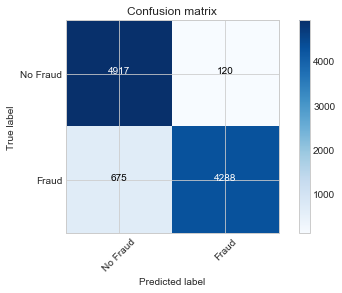

In [215]:
# Confusion matrix

cnf_matrix = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

So far, Naive Bayes performs worst among the models and because of the nature of this business the performance of this model is not acceptable.

## KNeighbors 

In [216]:
# from sklearn import preprocessing, model_selection, neighbors
# from sklearn.metrics import confusion_matrix, average_precision_score

#Start the timer as a measure of the computing effort
start_time = time.time()

KNN = KNeighborsClassifier()  #initialize the KNN classifier

# Create range of values to fit parameters
neighbors = [3,5,7]
weight_sys = ['distance','uniform']
parameters = {'n_neighbors': neighbors, 'weights': weight_sys}

# Fit parameters using gridsearch
clf = GridSearchCV(KNN, param_grid=parameters, cv=CF_no)

#Fit the tunned model on the training set
clf.fit(train_x,train_y)

# Print the best hyperparameters set
print("Best Hyper Parameters:", clf.best_params_)

#Initialize the model on test dataset
clf.fit(test_x, test_y)

# Predict on test dataset
y_pred = clf.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(clf.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

Best Hyper Parameters: {'n_neighbors': 3, 'weights': 'distance'}
--- 582 seconds ---


Confusion matrix, without normalization
[[5037    0]
 [   0 4963]]


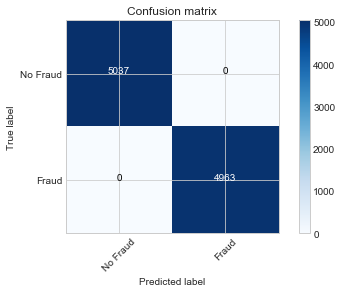

In [217]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [218]:
# Metrics computed from a confusion matrix

#cnf_matrix_metrics = metrics.confusion_matrix(test_y, pred_y)
#[row, column]
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

# Classification Accuracy: Overall, how often is the classifier correct?
print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 4963. 
True Negatives (TN): we correctly predicted that no fraud: 5037. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 0. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 0. 
Overall, how often is the classifier correct (accuracy)? 1.0. 
Overall, how often is the classifier incorrect? 0.0. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 1.0.
When the actual value is negative, how often is the prediction correct (specificity)? 1.0.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.0.
When a positive value is predicted, how often is the prediction correct (precision)? 1.0.


In [219]:
# Which metrics should you focus on?
# This is the case of fraud detection therefore we should optimize for sensitivity or recall:
# FN is in this case more important as false positives (normal transactions that are marked as possible fraud
# are more acceptable than false negatives where actual fraud has happened and we fail to detect

## Support Vector Machine

In [221]:
# Because of high cost of computation cost we do not tune the parameters here
# Otherwise here are the code in case we can afford it
## parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
## Fit parameters using gridsearch
## svc_tuned = GridSearchCV(svc, parameters, cv=CF_no)

#Start the timer as a measure of the computing effort
start_time = time.time()

# # Initialize and fit the model
svm = SVC(kernel = 'linear')
svm.fit(train_x, train_y)

# Predict on test dataset
y_pred = svm.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(svm.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

--- 16 seconds ---


Confusion matrix, without normalization
[[4951   86]
 [ 444 4519]]


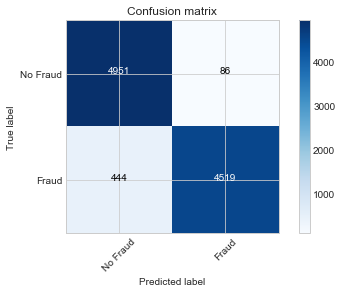

In [222]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [223]:
# Metrics computed from a confusion matrix

#cnf_matrix_metrics = metrics.confusion_matrix(test_y, pred_y)
#[row, column]
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

# Classification Accuracy: Overall, how often is the classifier correct?
print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 4519. 
True Negatives (TN): we correctly predicted that no fraud: 4951. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 86. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 444. 
Overall, how often is the classifier correct (accuracy)? 0.947. 
Overall, how often is the classifier incorrect? 0.053. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 0.9105379810598428.
When the actual value is negative, how often is the prediction correct (specificity)? 0.9829263450466548.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.017073654953345244.
When a positive value is predicted, how often is the prediction correct (precision)? 0.9813246471226927.


## Gradient Boost

In [224]:
# Here we collect the cross-validation average accuracy 
# for a number of estimators in the range (1, 20). 
# The loss function is the default one (multinomial negative log-likelihood):

Gradient_score_mean = []
max_estimators = 20
for i in range(1, max_estimators):
    score = cross_val_score(GradientBoostingClassifier(n_estimators=i, learning_rate=5.0/float(i)),
                            test_x, test_y, cv=10, scoring='accuracy').mean()
Gradient_score_mean.append(score)
print("Accuracy: {}".format(Gradient_score_mean))

Accuracy: [0.9727991845991845]


In [225]:
# Start the timer as a measure of the computing effort
start_time = time.time()

# We'll make 20 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 20,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
Gradeboost = ensemble.GradientBoostingClassifier(**params)
Gradeboost.fit(train_x, train_y)

# Predict on test dataset
y_pred = clf.predict(test_x)

# Check the prediction power of the model
pred_y = np.array(clf.predict(test_x))
true_y = np.array(test_y)

#Print the time required to fit and evaluate the model
print("--- %s seconds ---" % round((time.time() - start_time)))

--- 4 seconds ---


Confusion matrix, without normalization
[[5037    0]
 [   0 4963]]


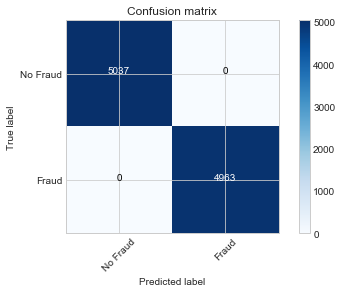

In [226]:
class_names = ['No Fraud', 'Fraud']
np.set_printoptions(precision=2)

cnf_matrix = confusion_matrix(true_y, pred_y)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix')
plt.show()

In [227]:
# Metrics computed from a confusion matrix

#cnf_matrix_metrics = metrics.confusion_matrix(test_y, pred_y)
#[row, column]
TP = cnf_matrix[1, 1]
TN = cnf_matrix[0, 0]
FP = cnf_matrix[0, 1]
FN = cnf_matrix[1, 0]

# Classification Accuracy: Overall, how often is the classifier correct?
# use float to perform true division, not integer division

print("True Positives (TP): We correctly predicted the fraud: {}. ".format(TP))
print("True Negatives (TN): we correctly predicted that no fraud: {}. ".format(TN))
print("False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: {}. ".format(FP))
print("False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: {}. ".format(FN))

print("===================================================")

# Classification Accuracy: Overall, how often is the classifier correct?
print("Overall, how often is the classifier correct (accuracy)? {}. ".format((TP + TN) / float(TP + TN + FP + FN)))      
print("Overall, how often is the classifier incorrect? {}. ".format((FP + FN) / float(TP + TN + FP + FN))) 
print("When the actual value is positive, how often is the prediction correct (sensitivity or recall)? {}.".format(TP / float(FN + TP))) 
print("When the actual value is negative, how often is the prediction correct (specificity)? {}.".format(TN / (TN + FP))) 
print("When the actual value is negative, how often is the prediction incorrect (false positive rate)? {}.".format(FP / float(TN + FP))) 
print("When a positive value is predicted, how often is the prediction correct (precision)? {}.".format(TP / float(TP + FP))) 

True Positives (TP): We correctly predicted the fraud: 4963. 
True Negatives (TN): we correctly predicted that no fraud: 5037. 
False Positives (FP): we incorrectly predicted that it is a fraud or Type I error: 0. 
False Negatives (FN): we incorrectly predicted that it is not a fraud or Type II error: 0. 
Overall, how often is the classifier correct (accuracy)? 1.0. 
Overall, how often is the classifier incorrect? 0.0. 
When the actual value is positive, how often is the prediction correct (sensitivity or recall)? 1.0.
When the actual value is negative, how often is the prediction correct (specificity)? 1.0.
When the actual value is negative, how often is the prediction incorrect (false positive rate)? 0.0.
When a positive value is predicted, how often is the prediction correct (precision)? 1.0.


The best models with 0% recalls are Random Forest, K Neighbohrs and Gradient Boosting. 